In [ ]:
# Tải dữ liệu gốc về, option `-nc` sẽ không download nếu tồn tại rồi.
# Giải nén dữ liệu, sau đó sẽ được thư mục `mail_dir`

!wget -nc http://www.cs.cmu.edu/~enron/enron_mail_20150507.tar.gz
!tar -xf enron_mail_20150507.tar.gz
# Xóa thư mục sender
!rm -rf sender/

--2021-06-15 04:58:39--  http://www.cs.cmu.edu/~enron/enron_mail_20150507.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 443254787 (423M) [application/x-gzip]
Saving to: ‘enron_mail_20150507.tar.gz’

enron_mail_20150507 100%[===================>] 422.72M  2.38MB/s    in 3m 37s  

2021-06-15 05:02:17 (1.95 MB/s) - ‘enron_mail_20150507.tar.gz’ saved [443254787/443254787]



In [ ]:
# Các cấu hình chung
DATA_DIR = "maildir" # Đường dẫn tới thư mục chứa dữ liệu gốc.
PREP_DATA_DIR = "sender" # Đường dẫn tới thư mục chứa dữ liệu đã tiền xử lý.
MIN_WORD_PER_EMAIL = 20

# Nếu các dòng trong nội dung email bắt đầu bởi các từ khóa dưới đây thì xóa bỏ.
IGNORE_KEYS = {
    'Message-ID:',
    'Date:',
    'From:',
    'To:',
    'Cc:',
    'cc:',
    'Mime-Version:',
    'Content-Type:',
    'Content-Transfer-Encoding:',
    'Bcc:',
    'X-From:',
    'X-To:',
    'X-cc:',
    'X-bcc:',
    'X-Folder:',
    'X-Origin:',
    'X-FileName:'
}

In [ ]:
import os
import traceback
import re

# Dữ liệu trước khi xử lý

In [ ]:
# In ra danh sách người gửi
import os
senders = os.listdir(DATA_DIR)
print(senders)

['lewis-a', 'zipper-a', 'holst-k', 'rapp-b', 'merriss-s', 'brawner-s', 'symes-k', 'williams-j', 'lay-k', 'mcconnell-m', 'panus-s', 'causholli-m', 'thomas-p', 'steffes-j', 'ring-a', 'sturm-f', 'tholt-j', 'donohoe-t', 'zufferli-j', 'baughman-d', 'whitt-m', 'quigley-d', 'carson-m', 'keavey-p', 'benson-r', 'rogers-b', 'donoho-l', 'presto-k', 'gang-l', 'giron-d', 'swerzbin-m', 'gay-r', 'schoolcraft-d', 'geaccone-t', 'bailey-s', 'smith-m', 'ring-r', 'sanchez-m', 'forney-j', 'ermis-f', 'buy-r', 'cash-m', 'mckay-b', 'quenet-j', 'maggi-m', 'motley-m', 'dorland-c', 'dickson-s', 'bass-e', 'badeer-r', 'skilling-j', 'germany-c', 'perlingiere-d', 'martin-t', 'scott-s', 'slinger-r', 'ward-k', 'wolfe-j', 'semperger-c', 'rodrique-r', 'dasovich-j', 'love-p', 'schwieger-j', 'lucci-p', 'pimenov-v', 'williams-w3', 'kuykendall-t', 'stokley-c', 'neal-s', 'townsend-j', 'meyers-a', 'solberg-g', 'kaminski-v', 'reitmeyer-j', 'whalley-l', 'kean-s', 'farmer-d', 'watson-k', 'crandell-s', 'lokey-t', 'grigsby-m', 'ki

In [ ]:
# In ra thử vài email
sample_senders = senders[:2]

for sender in sample_senders:
    sender_path = os.path.join(DATA_DIR, sender)
    categories = os.listdir(sender_path)
    print('Danh sách categories:', categories)
    print('\n--------------------\n')
    first_category_path = os.path.join(sender_path, categories[0])
    first_email_path = os.path.join(first_category_path, os.listdir(first_category_path)[0])
    content = open(first_email_path).read()
    print(sender, ':', content, '\n-------------------------\n')


Danh sách categories: ['inbox', '_sent_mail', 'all_documents', 'notes_inbox', 'discussion_threads', 'sent_items', 'calendar', 'sent', 'old_messages', 'deleted_items']

--------------------

lewis-a : Message-ID: <6273740.1075845229595.JavaMail.evans@thyme>
Date: Fri, 8 Jun 2001 07:35:28 -0700 (PDT)
From: alerts@alerts.equityalert.com
To: alewis@ect.enron.com
Subject: Your News Alert for YHOO
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: quoted-printable
X-From: "Equity Alert Center" <alerts@alerts.equityalert.com>@ENRON <IMCEANOTES-+22Equity+20Alert+20Center+22+20+3Calerts+40alerts+2Eequityalert+2Ecom+3E+40ENRON@ENRON.com>
X-To: Andrew Lewis <alewis@ect.enron.com>
X-cc: 
X-bcc: 
X-Folder: \Lewis, Andrew H.\Lewis, Andrew H.\Inbox
X-Origin: LEWIS-A
X-FileName: Lewis, Andrew H..pst


[IMAGE]=09[IMAGE]=09[IMAGE]=09


   Market  Watch   [IMAGE] Largest  Short Postition Decreases    [IMAGE] La=
rgest  Short Postition Increases   [IMAGE] Lock-up  Expi

# Xử lý dữ liệu

- Chỉ lấy dữ liệu là email được gửi đi
- Chỉ giữ lại email gửi đi
- Xóa bỏ các trường thông tin người gửi, người nhận
- Xóa các từ khóa (stopwrods) trong email: subject, forwarded, cc, bcc, ...
- Loại bỏ các email quá ngắn (dưới 20 words, có thể thay đổi)

In [ ]:
# Hàm làm sạch dữ liệu
def clean_data(email_lines):
    remains_lines = []
    word_count = 0
    for line in email_lines:
        key = line.split(':')
        if key[0] + ':' in IGNORE_KEYS:
            continue
        if '-----Original Message-----' in line:
            break
        if 'Forwarded by ' in line:
            return []
        line = line.strip()
        line = re.sub(r'\s+', ' ', line)
        line = re.sub(r'^Subject', '', line)
        line = re.sub(r'[^\w\d]+', ' ', line)
        line = re.sub(r'\s{2,}', ' ', line).strip()
        if len(line) > 0:
            remains_lines.append(line)
            word_count += len(line.split())
    if word_count < MIN_WORD_PER_EMAIL:
        return []
    return remains_lines

In [ ]:
# Hàm tiền xử lý chính:
# - Lấy email gửi đi của mỗi người
# - Tiền xử lý bằng cách gọi tới hàm `clean_data` ở trên, nếu clean = True
# - Lưu lại vào thư mục PREP_DATA_DIR, mỗi người dùng một thư mục riêng
mail_id = {}
def separate_by_sender():
    for name in os.listdir(DATA_DIR):
        name_parts = name.lower().split('-')
        if len(name_parts) != 2:
            # print(name)
            continue
        name_path = os.path.join(DATA_DIR, name)
        for r, d, f in os.walk(name_path):
            for file in f:
                try:
                    email_path = os.path.join(r, file)
                    lines = open(email_path).read().splitlines()
                    if len(lines) > 3 and lines[2].startswith('From:'):
                        sender = re.sub(r'From: ([^@]+)@.+', r'\1', lines[2]).lower()
                        sender_parts = [x for x in sender.split('.') if len(x) > 0]
                        if len(sender_parts) != 2:
                            # print(lines[2])
                            continue
                        if sender_parts[1] == name_parts[0] and sender_parts[0].startswith(name_parts[1]):
                            sender_dir = os.path.join(PREP_DATA_DIR, name)
                            if not os.path.exists(sender_dir):
                                os.mkdir(sender_dir)
                            if sender not in mail_id:
                                mail_id[sender] = 1
                            lines = clean_data(lines)
                            if len(lines) > 0:
                                with open(os.path.join(sender_dir, str(mail_id[sender]) + '.txt'), 'w') as fp:
                                    fp.write('\n'.join(lines))
                                mail_id[sender] = mail_id[sender] + 1
                except UnicodeDecodeError:
                    pass
                except:
                    traceback.print_exc()

# Tạo thư mục PREP_DATA_DIR nếu chưa có
import os

if not os.path.exists(PREP_DATA_DIR):
    os.mkdir(PREP_DATA_DIR)
separate_by_sender()

# Quan sát dữ liệu sau khi xử lý

In [ ]:
sample_senders = os.listdir(PREP_DATA_DIR)[:2]
print(sample_senders)
for sender in sample_senders:
    first_email_path = os.path.join(PREP_DATA_DIR, sender, '1.txt')
    content = open(first_email_path).read()
    print(sender, ':', content)
    print('\n----------------------------------\n')

['lewis-a', 'zipper-a']
lewis-a : Re SITARA Access change
Regina
I need access to the Central Intramonth deal tickets Trade Blotter and Deal
Manager and Position Manager
Thanks
Andy

----------------------------------

zipper-a : EDS Arcordia set up meeting Kolodgie
Spoke with Kolodgie Arcordia is run out of London will get something set up for NYC

----------------------------------



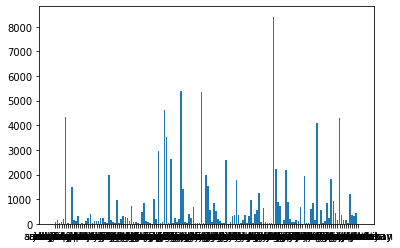

<Figure size 21600x28800 with 0 Axes>

In [ ]:
# Thống kê số email gửi đi của mỗi users
import matplotlib.pyplot as plt
plt.bar(range(len(mail_id)), list(mail_id.values()), align='center')
plt.xticks(range(len(mail_id)), list(mail_id.keys()))
plt.figure(figsize=(300,400))
plt.show()

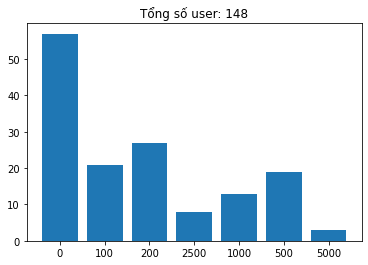

In [ ]:
# Thống kê số người dùng có số email gửi đi ở các mức
levels = [5000, 2500, 1000, 500, 200, 100, 0]
count = {}
for key in mail_id:
    for level in levels:
        if mail_id[key] > level:
            count[level] = count.get(level, 0) +1
            break

plt.bar(range(len(count)), list(count.values()), align='center')
plt.xticks(range(len(count)), list(count.keys()))
plt.title('Tổng số user: ' + str(len(mail_id)))
plt.show()

# Kết quả quan sát
- Chỉ có 148/150 user có dữ liệu email gửi đi
- Số lượng emails trên mỗi user có chênh lệch lớn => Vấn đề mất cân bằng dữ liệu
- Khó khăn khi phân loại (xác định người gửi) nhiều users
- Rất khó khi phân loại user có ít emails

## Đề xuất
- Chỉ nên phân loại top 20 (hoặc ít hơn) user có nhiều email nhất
- Lấy số lượng dữ liệu huấn luyện của mỗi user bằng số lượng email của user có ít email nhất




# Huấn luyện
- Mô hình SMV
- Mô hình Multi-layer Perceptron

Tuy nhiên, trước khi huấn luyện được mô hình ta cần:

1. Viết hàm load dữ liệu
2. Tạo tập train/test
3. Viết pipeline model
4. Huấn luyện
5. Đánh giá

In [ ]:
# load dữ liệu
# max_count: Số email tối đa của mỗi user. Nếu user có nhiều email hơn max_count thì sẽ bỏ bớt
# min_count: Số email tối thiểu của mỗi user. Nếu user có ít email hơn min_count thì sẽ bỏ qua
# n_classes: Số lượng user muốn đọc ra
def load_data(max_count=-1, min_count=-1, n_classes=-1):
    emails = []
    senders = []
    n_class = 0
    for sender in os.listdir(PREP_DATA_DIR):
        sender_path = os.path.join(PREP_DATA_DIR, sender)
        email_files = [os.path.join(sender_path, x) for x in os.listdir(sender_path)]
        if min_count != -1 and len(email_files) < min_count:
            continue
        if max_count != -1:
            email_files = email_files[:max_count]

            n_class += 1
            if n_classes != -1 and n_class > n_classes:
                break

            for email_file in email_files:
                emails.append(open(email_file).read())
                senders.append(sender)
    return emails, senders

In [ ]:
# Xây dựng model

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier


def init_pipeline(clf):
    pipe_line = Pipeline([
        ("vect", CountVectorizer(
            ngram_range=(1, 2),
            max_df=0.9,
            min_df=0.1
        )),  # bag-of-words
        ("tfidf", TfidfTransformer()),  # tf-idf
        ("clf", clf)  # model
    ])

    return pipe_line


class NaiveBayesModel(object):
    def __init__(self):
        self.clf = init_pipeline(MultinomialNB())


class SVMModel(object):
    def __init__(self):
        self.clf = init_pipeline(SGDClassifier())


class LogisticRegressionModel(object):
    def __init__(self):
        self.clf = init_pipeline(LogisticRegression())


class DecisionTreeModel(object):
    def __init__(self):
        self.clf = init_pipeline(DecisionTreeClassifier())


class MLPModel(object):
    def __init__(self):
        self.clf = init_pipeline(MLPClassifier(
            max_iter=1000
        ))

In [ ]:

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Lấy dữ liệu ra, có thể thay đổi giá trị tham số (số nhãn là 5)
X, y = load_data(min_count=1000, max_count=1000, n_classes=5)

# Chuyển nhãn (tên người dùng) sang vector số
le = LabelEncoder()
y = le.fit_transform(y)

# Tách train, test theo tỉ lệ 7:3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Size train: ', len(X_train))
print('Size test: ', len(X_test))
print('n_classes:', len(le.classes_))

Size train:  3500
Size test:  1500
n_classes: 5


In [ ]:
# SVM
model = SVMModel()

clf = model.clf.fit(X_train, y_train)

pred = clf.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       290
           1       0.90      0.91      0.90       301
           2       0.88      0.88      0.88       309
           3       0.99      0.95      0.97       284
           4       0.98      0.94      0.96       316

    accuracy                           0.91      1500
   macro avg       0.91      0.91      0.91      1500
weighted avg       0.91      0.91      0.91      1500



In [ ]:
# MLP
model = MLPModel()

clf = model.clf.fit(X_train, y_train)

pred = clf.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       290
           1       0.94      0.95      0.95       301
           2       0.93      0.90      0.91       309
           3       0.97      0.98      0.98       284
           4       0.99      0.97      0.98       316

    accuracy                           0.95      1500
   macro avg       0.95      0.95      0.95      1500
weighted avg       0.95      0.95      0.95      1500



In [ ]:
# Dự đoán
for email, sender in zip(X_test, y_test):
    pred_sender = clf.predict([email])[0]
    print(pred_sender)
    print('Real user:', le.inverse_transform([sender])[0])
    print('Pred user:', le.inverse_transform([pred_sender])[0])

# Hoặc nhập email tại đây (bỏ comment)
# email = ""
# email = clean_data(email)
# pred_sender = clf.predict([email])[0]
# print('Pred user:', le.inverse_transform([pred_sender])[0])

0
Real user: mcconnell-m
Pred user: bass-e
3
Real user: rogers-b
Pred user: rogers-b
3
Real user: rogers-b
Pred user: rogers-b
2
Real user: mcconnell-m
Pred user: mcconnell-m
4
Real user: symes-k
Pred user: symes-k
4
Real user: symes-k
Pred user: symes-k
4
Real user: symes-k
Pred user: symes-k
3
Real user: rogers-b
Pred user: rogers-b
3
Real user: rogers-b
Pred user: rogers-b
0
Real user: mcconnell-m
Pred user: bass-e
3
Real user: rogers-b
Pred user: rogers-b
4
Real user: symes-k
Pred user: symes-k
4
Real user: symes-k
Pred user: symes-k
4
Real user: symes-k
Pred user: symes-k
1
Real user: dorland-c
Pred user: dorland-c
1
Real user: dorland-c
Pred user: dorland-c
2
Real user: mcconnell-m
Pred user: mcconnell-m
1
Real user: dorland-c
Pred user: dorland-c
2
Real user: mcconnell-m
Pred user: mcconnell-m
2
Real user: mcconnell-m
Pred user: mcconnell-m
4
Real user: symes-k
Pred user: symes-k
1
Real user: dorland-c
Pred user: dorland-c
2
Real user: mcconnell-m
Pred user: mcconnell-m
4
Real u